# 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import math
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelBinarizer
import warnings


import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

import lime
import lime.lime_tabular
from lime import submodular_pick

import shap

pd.options.display.max_rows = 250

# 2. Read/Clean Data

In [2]:
df = pd.read_csv("boston_airbnb_listings.csv")

In [3]:
df.describe()

,id,scrape_id,host_id,host_response_rate,latitude,longitude,accommodates,square_feet,cleaning_fee,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.580000e+03,3.580000e+03,3.580000e+03,3109.000000,3580.000000,3580.000000,3580.000000,51.000000,2475.00000,3580.000000,2767.000000,2757.000000,2762.000000,2760.000000,2762.000000,2758.000000,2759.000000,3580.000000,2824.000000
mean,8.446173e+06,2.020000e+13,2.493719e+07,0.949810,42.340035,-71.084814,3.037430,942.352941,68.36202,3.173743,91.910734,9.431266,9.257422,9.645652,9.645909,9.414068,9.167814,12.748603,1.968821
std,4.496934e+06,0.000000e+00,2.292148e+07,0.125261,0.024398,0.031530,1.772393,572.192584,51.31972,8.880063,9.538538,0.932447,1.169759,0.763295,0.736019,0.904014,1.011769,29.432946,2.119503
min,3.353000e+03,2.020000e+13,4.240000e+03,0.000000,42.235942,-71.171789,1.000000,90.000000,5.00000,1.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000
25%,4.693531e+06,2.020000e+13,6.103425e+06,0.970000,42.329992,-71.105048,2.000000,540.000000,25.00000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.480000
50%,8.578710e+06,2.020000e+13,1.928100e+07,1.000000,42.345197,-71.078458,2.000000,875.000000,50.00000,2.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.170000
75%,1.279115e+07,2.020000e+13,3.622561e+07,1.000000,42.354686,-71.062186,4.000000,1200.000000,100.00000,3.000000,98.500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.720000
max,1.493346e+07,2.020000e+13,9.385411e+07,1.000000,42.389982,-71.000100,16.000000,2400.000000,300.00000,300.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000


In [4]:
df.dtypes

id                                    int64
listing_url                          object
scrape_id                           float64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
neighborhood_overview                object
notes                                object
transit                              object
access                               object
interaction                          object
house_rules                          object
host_id                               int64
host_name                            object
host_since                           object
host_location                        object
host_about                           object
host_response_time                   object
host_response_rate                  float64
host_acceptance_rate                 object
host_is_superhost               

In [5]:
#Datatype correction
df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'], errors='coerce')
df['host_listings_count'] = pd.to_numeric(df['host_listings_count'], errors='coerce')
df['host_total_listings_count'] = pd.to_numeric(df['host_total_listings_count'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['weekly_price'] = pd.to_numeric(df['weekly_price'], errors='coerce')
df['monthly_price'] = pd.to_numeric(df['monthly_price'], errors='coerce')
df['security_deposit'] = pd.to_numeric(df['security_deposit'], errors='coerce')
df['guests_included'] = pd.to_numeric(df['guests_included'], errors='coerce')
df['extra_people'] = pd.to_numeric(df['extra_people'], errors='coerce')
df['maximum_nights'] = pd.to_numeric(df['maximum_nights'], errors='coerce')
df['availability_30'] = pd.to_numeric(df['availability_30'], errors='coerce')
df['availability_60'] = pd.to_numeric(df['availability_60'], errors='coerce')
df['availability_90'] = pd.to_numeric(df['availability_90'], errors='coerce')
df['availability_365'] = pd.to_numeric(df['availability_365'], errors='coerce')
df['number_of_reviews'] = pd.to_numeric(df['number_of_reviews'], errors='coerce')

In [6]:
#One-hot encoding
df = pd.get_dummies(df, columns=['property_type'], prefix = ['property'])
df = pd.get_dummies(df, columns=['room_type'], prefix = ['room'])
df = pd.get_dummies(df, columns=['bed_type'], prefix = ['bed'])
df = pd.get_dummies(df, columns=['cancellation_policy'], prefix = ['cancellation'])

In [7]:
df.fillna(0, inplace = True)

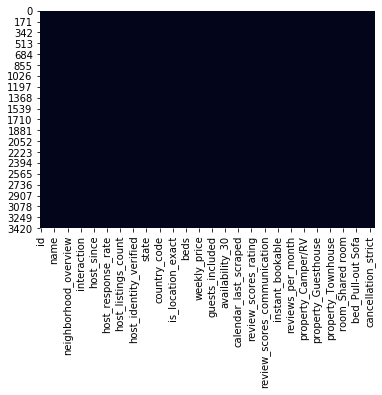

In [8]:
sns.heatmap(df.isnull(), cbar=False)

# 3. Vader Sentiment Analysis

In [9]:
vaderAnalyzer = SentimentIntensityAnalyzer()

df['description'] = df['description'].astype(str)

df['vaderScores'] = df['description'].apply(vaderAnalyzer.polarity_scores)

In [10]:
df[['Vader_neg','Vader_neu','Vader_pos','Vader_compound']] = json_normalize(df['vaderScores'])

# 4. Build Feature Set

In [11]:
df.dtypes

id                                    int64
listing_url                          object
scrape_id                           float64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
neighborhood_overview                object
notes                                object
transit                              object
access                               object
interaction                          object
house_rules                          object
host_id                               int64
host_name                            object
host_since                           object
host_location                        object
host_about                           object
host_response_time                   object
host_response_rate                  float64
host_acceptance_rate                float64
host_is_superhost               

In [12]:
X = df[['host_response_rate','host_acceptance_rate','host_is_superhost','host_has_profile_pic',
        'host_identity_verified','latitude','longitude','accommodates','bathrooms',
        'bedrooms','beds','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights',
        'maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
        'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license',
        'instant_bookable','require_guest_profile_picture','require_guest_phone_verification','reviews_per_month',
        'Vader_neg','Vader_neu','Vader_pos','Vader_compound',"property_Apartment", 
        "property_Bed & Breakfast", "property_Boat", "property_Camper/RV", "property_Condominium", "property_Dorm", "property_Entire Floor", 
        "property_Guesthouse", "property_House", "property_Loft", "property_Other", "property_Townhouse", "property_Villa", "room_Entire home/apt", 
        "room_Private room", "room_Shared room", "cancellation_flexible", "cancellation_moderate", "cancellation_strict", 
        "cancellation_super_strict_30",'bed_Airbed','bed_Couch','bed_Futon','bed_Pull-out Sofa','bed_Real Bed']]

y = df['price']

In [13]:
# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# 5. Model Creation - Random Forest

In [14]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [15]:
y_pred = model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

71.21276401017226

In [17]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [18]:
regression_results(y_test,y_pred)

explained_variance:  0.5908
mean_squared_log_error:  0.2305
r2:  0.5899
MAE:  47.5689
MSE:  5071.2578
RMSE:  71.2128


In [19]:
feature_imp_df = pd.DataFrame(list(zip(X.columns, model.feature_importances_)), 
               columns =['Features', 'Importances']).sort_values('Importances', ascending = False)
top10_feature_imps = feature_imp_df.head(10)

top10_feature_imps = top10_feature_imps.sort_values('Importances', ascending = True)

Text(0.5, 1.0, 'Top 10 Features by Importance')

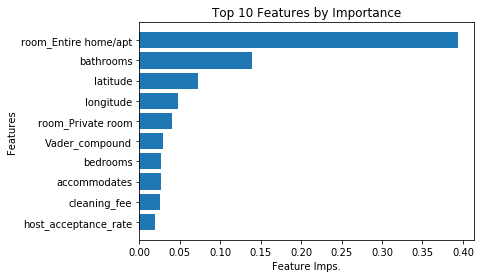

In [20]:
#plt.bar(X.columns, model.feature_importances_)
plt.barh(top10_feature_imps.Features, top10_feature_imps.Importances)
plt.xlabel('Feature Imps.')
plt.ylabel('Features')
plt.title('Top 10 Features by Importance')

# 6. LIME

In [21]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['price'], verbose=True, mode='regression')

In [22]:
j = 37
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=6)

Intercept 217.50194989340736
Prediction_local [198.11940671]
Right: 202.80581556890178


In [23]:
exp.show_in_notebook(show_table=True)

In [24]:
X_test[j:j+1].transpose()

,3069
host_response_rate,0.98
host_acceptance_rate,0.55
host_is_superhost,False
host_has_profile_pic,True
host_identity_verified,True
latitude,42.353
longitude,-71.0467
accommodates,3
bathrooms,1
bedrooms,1


In [25]:
y_test[j:j+1]

3069    169.0
Name: price, dtype: float64

# 7. Shapley

In [26]:
shap_explainer = shap.TreeExplainer(model)
shap_values_test = shap_explainer.shap_values(X_test)
shap_values_train = shap_explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [27]:
df_shap_test = pd.DataFrame(shap_values_test, columns=X_test.columns.values)
df_shap_train = pd.DataFrame(shap_values_train, columns=X_train.columns.values)

In [28]:
shap.initjs()
j=37
shap.force_plot(shap_explainer.expected_value, shap_values_test[j], X_test.iloc[[j]])

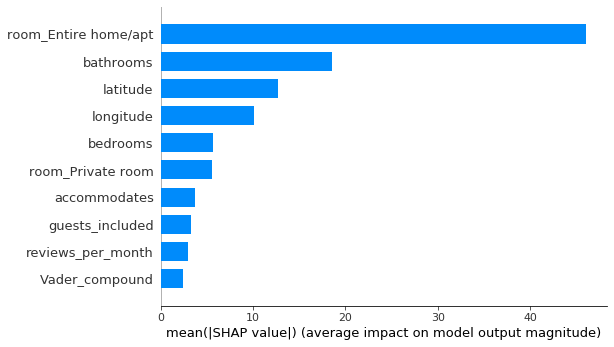

In [29]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", title= 'Mean SHAP Values', max_display = 10)

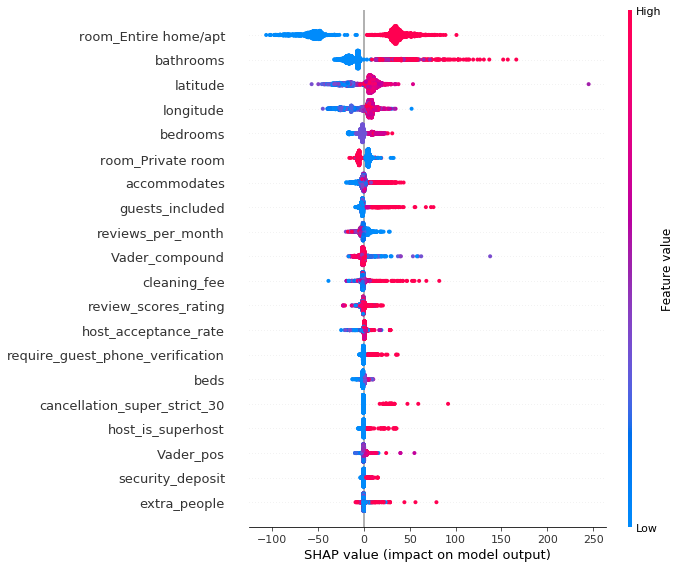

In [31]:
shap.summary_plot(shap_values_train, X_train)

In [32]:
df.price.mean()

168.47513966480446

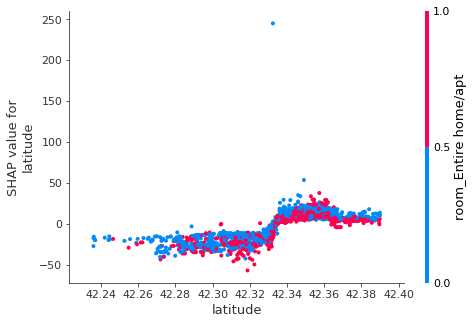

In [33]:
shp_plt = shap.dependence_plot("latitude", shap_values_train, X_train)

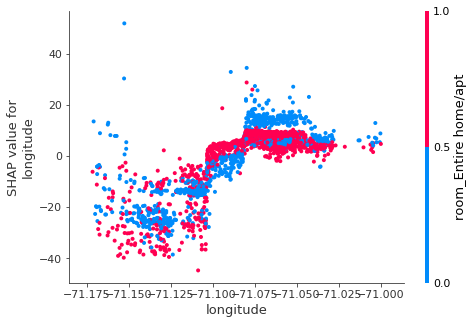

In [34]:
shp_plt = shap.dependence_plot("longitude", shap_values_train, X_train)

In [35]:
long_lat_shap_values = df_shap_train['latitude']+df_shap_train['longitude']
max(long_lat_shap_values) 

239.74023859396166

In [36]:
scaled_long_lat_shap_values = (long_lat_shap_values - long_lat_shap_values.min()) / long_lat_shap_values.ptp()
colors = plt.cm.coolwarm(scaled_long_lat_shap_values)

scaled_long_lat_shap_values.min(), scaled_long_lat_shap_values.max()

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


(0.0, 1.0)

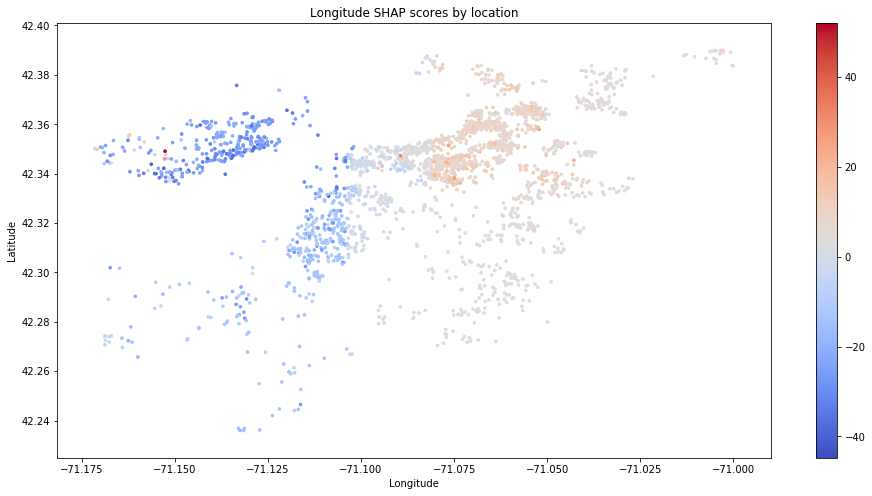

In [195]:
plt.figure(figsize=(16, 8))
plt.scatter(X_train['longitude'], X_train['latitude'], c=df_shap_train['longitude'], cmap=plt.cm.coolwarm, s =7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Longitude SHAP scores by location')
plt.colorbar()
#plt.scatter(x, y, marker='+', edgecolors=colors, s=150, linewidths=4)
